In [1]:
%%capture

import os
os.chdir("..")

from dotenv import load_dotenv
load_dotenv()

from IPython.display import Markdown, display
import json

from notebooks import experiment_utils
from app.core.container import Container
from app.interface.api.messages.schema import MessageRequest

# graph rendering
import nest_asyncio
nest_asyncio.apply()

# start dependency injection container
container = Container()
container.init_resources()
container.wire(modules=[__name__])

In [2]:
agent = experiment_utils.create_xai_agent(
    agent_type="agreement_planner",
    llm_tag="grok-2-vision",
    api_key=os.getenv("XAI_API_KEY"),
)

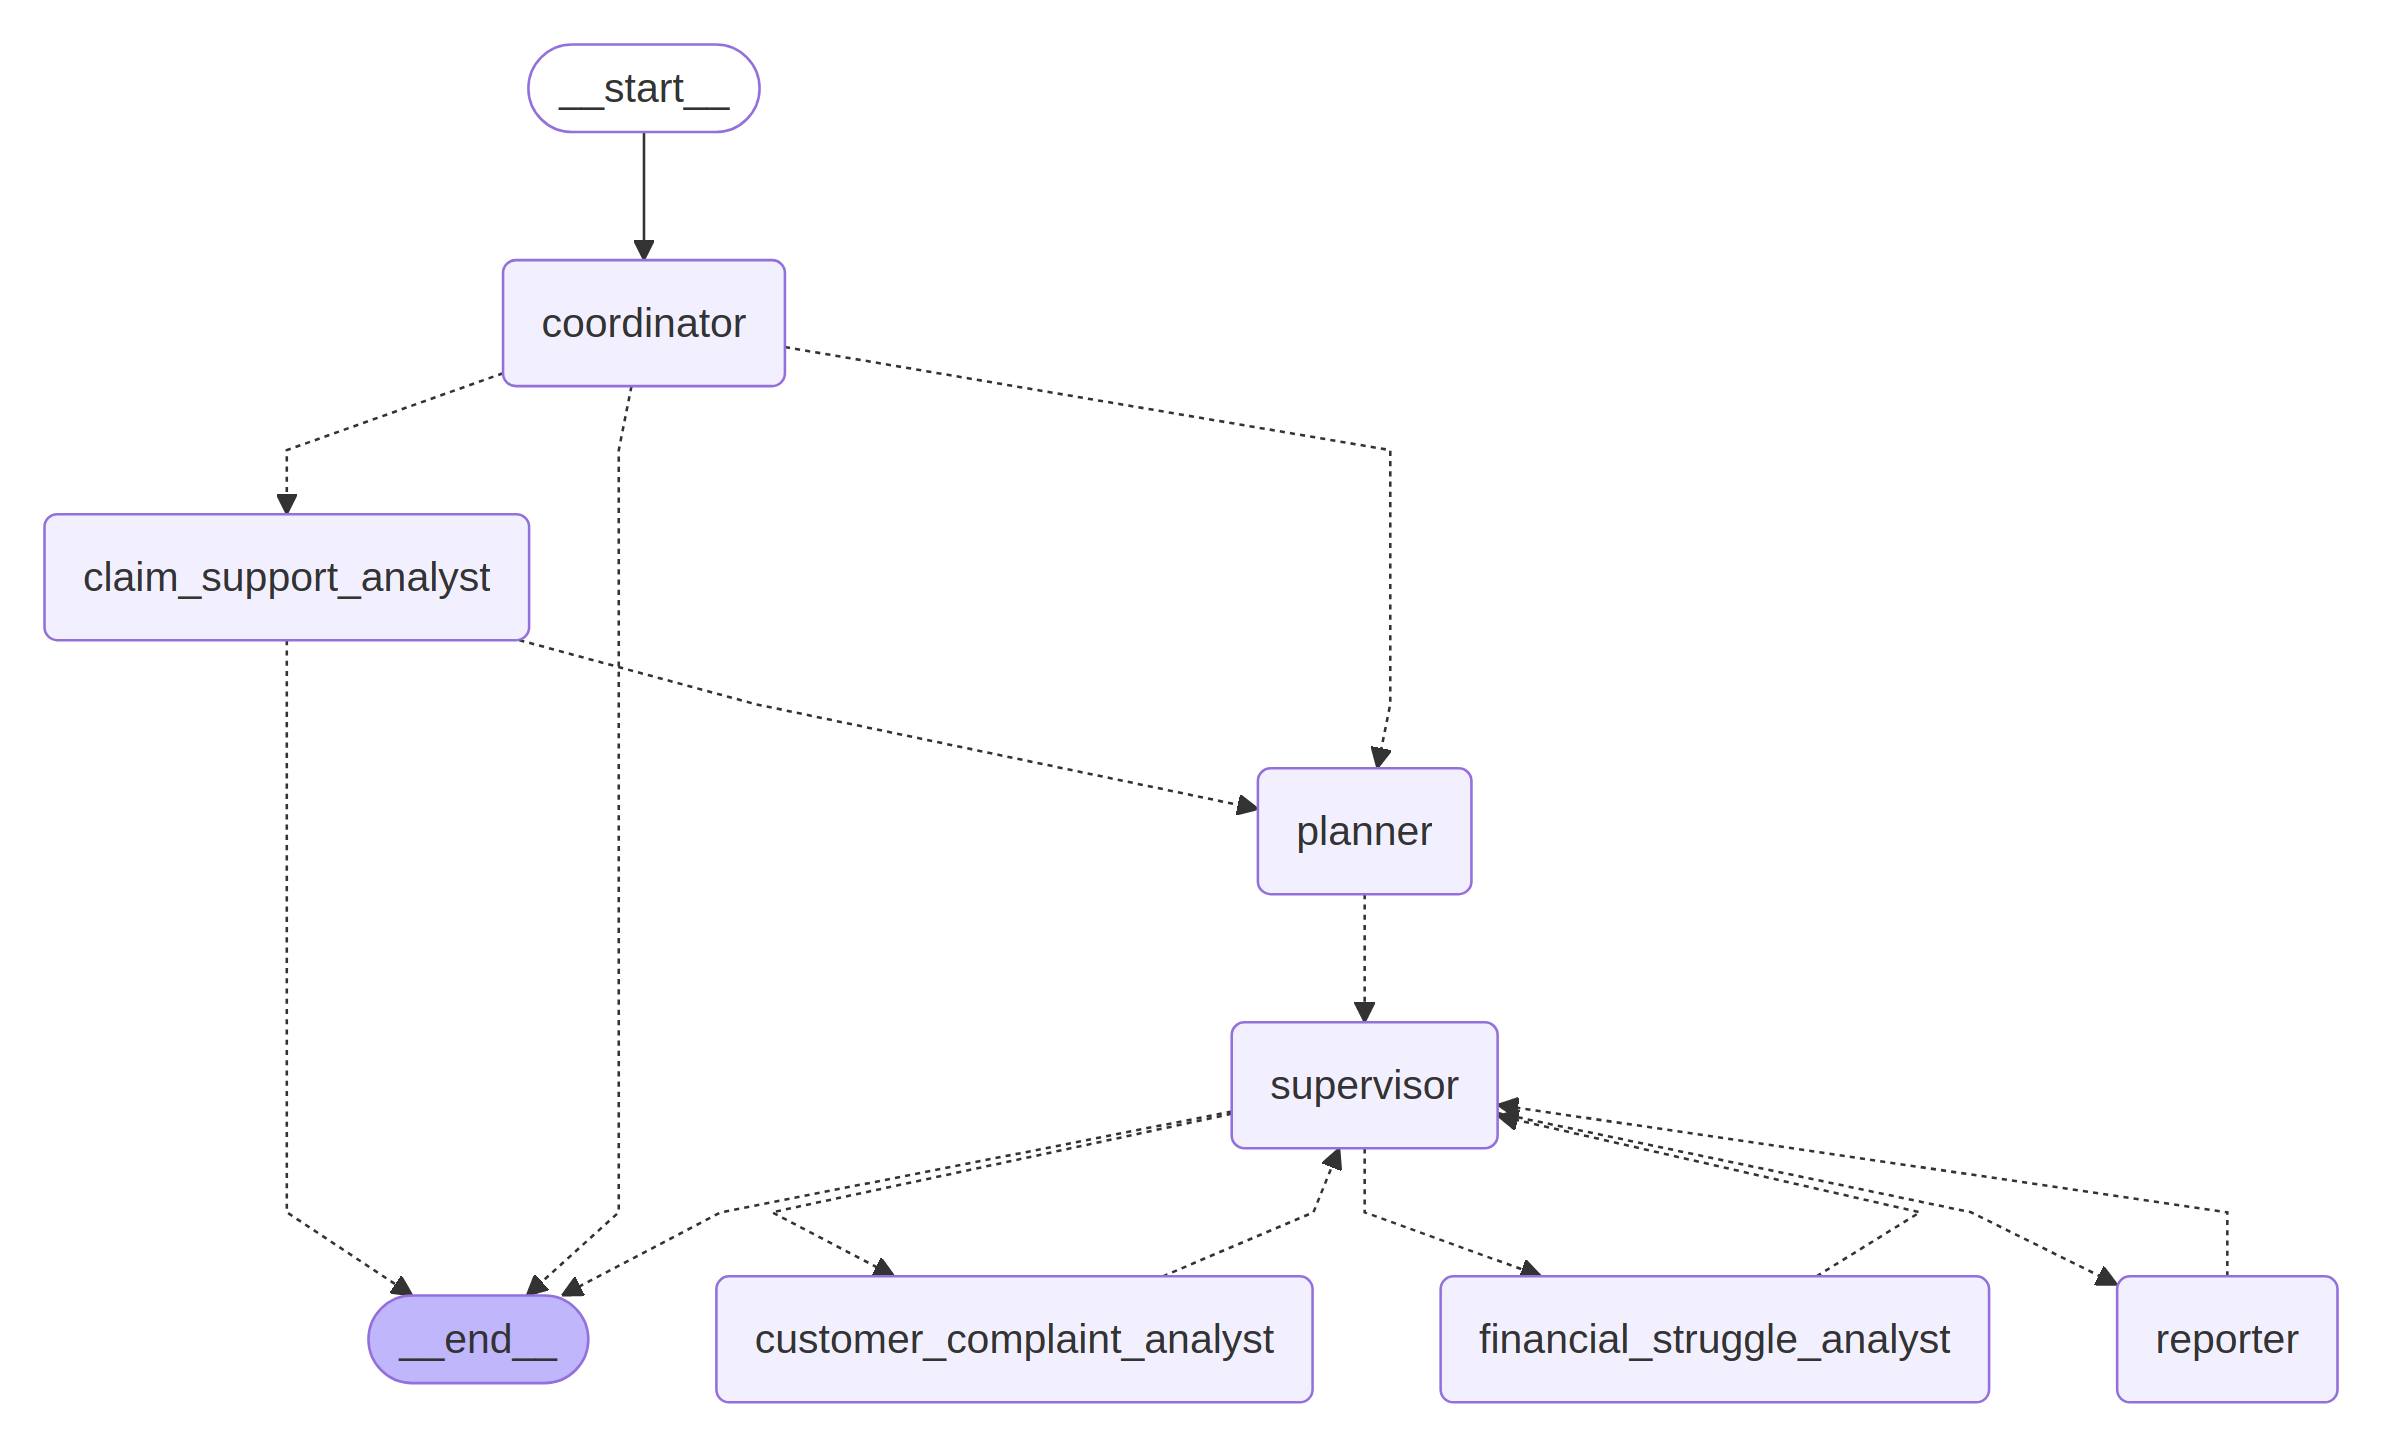

In [3]:
# get agent instance
agreement_planner_agent = container.agreement_planner_agent()

# get checkpointer instance
graph_persistence_factory = container.graph_persistence_factory()
checkpointer = graph_persistence_factory.build_checkpoint_saver()

# get config
agent_config = agreement_planner_agent.get_config(agent["id"])

# Create Graph
workflow_builder = agreement_planner_agent.get_workflow_builder(
    agent["id"]
)
workflow = workflow_builder.compile(checkpointer=checkpointer)
experiment_utils.print_graph(workflow)

In [ ]:
message_content = ""
message = MessageRequest(
    message_role="human",
    message_content=message_content,
    agent_id=agent["id"],
)

inputs = agreement_planner_agent.get_input_params(message)
result = workflow.invoke(inputs, agent_config)
ai_message_content, workflow_state = (
    agreement_planner_agent.format_response(result)
)

In [ ]:
display(Markdown(f"**AI Message Content:**\n\n{ai_message_content}\n\n---"))
display(
    Markdown(
        f"**Execution Plan:**\n```json\n{json.dumps(workflow_state.get('execution_plan'), ensure_ascii=False, indent=2)}\n```"
    )
)